In [1]:
import numpy as np
from databroker import databroker as DB
import databroker
import numpy.ma as ma
from csxtools.image_corr import clean_images, extract_darkfield

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
def xpcs(image_sequence, box, delta_t):
    """
    
    Paramaters
    ----------
    image_sequence : iterable
        iterable of ndarray
        
    box : tuple
        indexes of rectanglar ROI
        
        (col_left, row_bottom, col_right, row_top)  with 0, 0 in lower left
        
    delta_t : float
        time lag between frames
        
    Returns
    -------
    t_arr : array
        Delay time array
        
    F : array
        corrolation function
        
    Err : array
        error in F
    """
    y = box[2] - box[0]
    x = box[3] - box[1]

    # this is t, x, y
    image_sequence = list(image_sequence)
    z = len(image_sequence)
    stack = np.zeros((x, y, z))
    
    q_mean = 0
    
    for j, im in enumerate(image_sequence):
        q = im[box[1]:box[3], box[0]:box[2]]
        qm = np.mean(q)
        stack[:, :, j] = q/qm
        q_mean += qm
        
      
    q_mean = q_mean / z
    
      
    F = list()  #F=N.zeros((1,z-1)) # initialise F(Q,t)
    
    Err = list() # set up error
    
    G = np.zeros((x,y,z-1))#initialise pixel matrix
    
    I0 = np.mean(stack, axis=2) #average each pixel values over the whole of time of measurement
    
    I02 = I0*I0
    
    s = I0 > 1000/q_mean  #(N.max(q) - (6*N.std(q)))/N.mean(q)
    stack = stack * s[:, :, np.newaxis]
    #img1 = N.double(stack*s)
       
    ii = 0
    
    m = 0

    t_arr = []
    
    f = delta_t   # calc from time made and modified
    
    for i in range(stack.shape[-1] - 1): #number of time steps is number of images - 1
        jj = -1
        ii = ii + 1
    
        t_arr.append((i+1)*f)
        
        num1 = np.zeros((x, y), dtype=np.double)
        
        for j in range(len(stack[0,0,:])-ii): #increasing time diff means less pictures to average
        
            jj=jj+1
            
            m=ii+jj
            
            #aa = N.average(stack[:,:,jj])
            
            #bb = N.average(stack[:,:,m])
            
            num1 = num1 + (((stack[:,:,jj]))*((stack[:,:,m]))) # calculates the product of 2 images an equal timestep
            
            
        # apart and adds this to the array num1
 
        
        G[:,:,ii-1] = ((num1/(z-ii))/I02) # average the g2 calculated by the number of times you went through the loop
        
        p = ma.masked_equal(G, 0) # i.e. (z-ii)
        
        F.append(np.mean(p))
        
        Err.append(np.std(p) / np.sqrt(z-ii)) ## error from st.deviation/sqrt(N)
    
    return t_arr, F, Err


In [ ]:
# Analysis begins here, every thing above is function definitions

## extract the dark frames to use for normalizing the images

In [214]:
# the order is gain (1, 2, 8)
dark_uids = (56562, 56563, 56564)

dark_images = [extract_darkfield(DB.DataBroker[scan_id], 'fccd_image_lightfield') for scan_id in dark_uids]

## select which scan you want to use for the light field

In [234]:
h = DB.DataBroker[56574]
#evs = DB.get_events(h)
#[e for e in evs if len(e['data'])> 1]

#  image clean up

This function does the following things:
  - pivots the many frames per event into many events with a single frame
  - zips the image data with the fccd_stats flyer
  - uses the timestamp from the flyer for the timestamps on the pivoted events
  - background subtracts and gain-corrects the images
  
`clean_images` is a genenerator, the `list` materializes it and forces all of the computation to happen

In [236]:
res = list(clean_images(h, 'fccd_image_lightfield', 'fccd_flyer5', dark_images=dark_images ))
res

[{'data': {'_ind': 0,
   'fccd_flyer5': 3828028928.0,
   'fccd_image_lightfield': array([[4329, 4320, 4298, ..., 4249, 4264, 4003],
          [4300, 4325, 4292, ..., 4301, 4271, 3987],
          [4300, 4330, 4302, ..., 4264, 4247, 3961],
          ..., 
          [3949, 3965, 3978, ..., 3937, 3959, 3926],
          [3948, 3983, 3970, ..., 3948, 3968, 3951],
          [3948, 3982, 3974, ..., 3962, 3975, 3954]], dtype=uint16),
   'fccd_image_lightfield_corrected': array([[ 116.5,  106. ,   85. , ...,  136. ,  150.5,  -82.5],
          [  88.5,  111. ,   81.5, ...,  186.5,  158. ,  -98. ],
          [  89.5,  117.5,   92. , ...,  148. ,  133. , -127. ],
          ..., 
          [ -84.5,  -74. ,  -60.5, ..., -125. ,  -99. , -132. ],
          [ -84. ,  -53. ,  -68. , ..., -112.5,  -95. , -108. ],
          [ -85. ,  -54. ,  -61.5, ...,  -96. ,  -85.5, -103. ]]),
   'sx': 0.549998753,
   'sy': -0.3999998133242977,
   'sz': 0.7800015613728214,
   'temp_a': 119.97,
   'temp_b': 119.816},
  '

### Select a ROI

Look at the first image and find a brag spot of interest.  The order is (xmin, ymin, xmax, ymax)

<IPython.core.display.Javascript object>


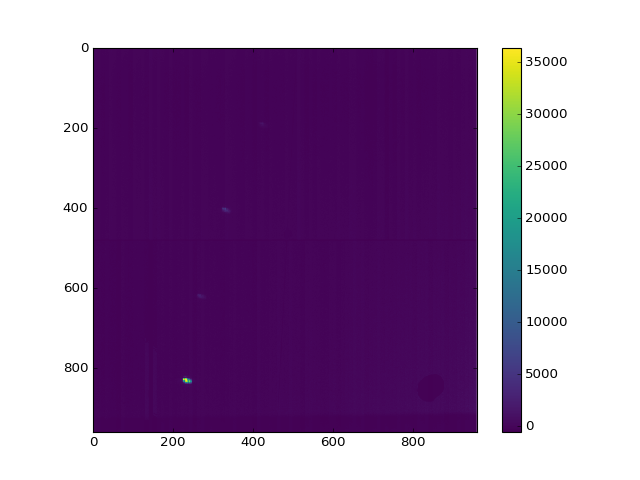

In [237]:
dd = res[1]
fig, ax = plt.subplots()
im = ax.imshow(dd['data']['fccd_image_lightfield_corrected'], interpolation='none', cmap='viridis')
fig.colorbar(im)

<IPython.core.display.Javascript object>


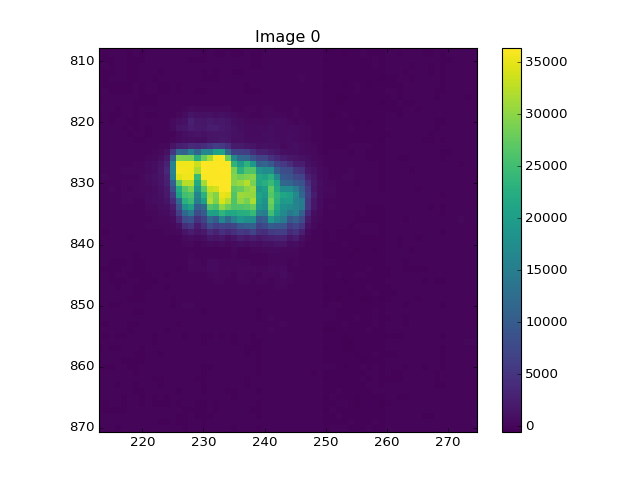

In [238]:
from ipywidgets import interact

fig, ax = plt.subplots()
im = ax.imshow(res[0]['data']['fccd_image_lightfield_corrected'], cmap='viridis', interpolation='nearest')
fig.colorbar(im)
def browse_images(res):
    N = len(res)
    def view_image(i=0):
        im.set_data(res[i]['data']['fccd_image_lightfield_corrected'])
        ax.set_title('Image {0}'.format(i))
        fig.canvas.draw_idle()
    interact(view_image, i=(0, N-1))
    

In [239]:
browse_images(res)

In [240]:
import skxray.core.correlation as corr
import skimage

In [241]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, binary_dilation
from skimage.measure import regionprops
from skimage.color import label2rgb

In [242]:
work_image = res[0]['data']['fccd_image_lightfield_corrected']
thresh = threshold_otsu(work_image)
peak_mask = work_image > thresh
peak_mask = binary_dilation(peak_mask, np.ones((15, 15)))
label_array = label(peak_mask)

In [243]:
thresh

12194.3779296875

<IPython.core.display.Javascript object>


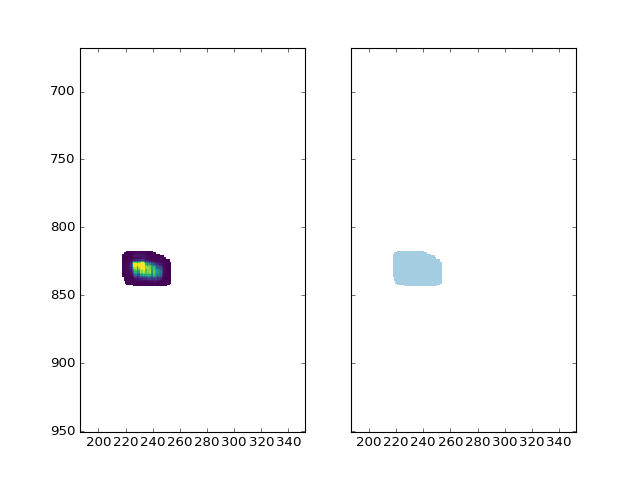

In [244]:
fig, (ax, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
tmp = np.array(work_image)
tmp[~peak_mask] = np.nan
ax.imshow(tmp, cmap='viridis', interpolation='none')
t_label = label_array.astype('float')
t_label[label_array==0] = np.nan
ax2.imshow(t_label, cmap='Paired', interpolation='none')



In [223]:
from skimage.measure import regionprops

In [246]:
def _flipper(a, b, c, d):
    
    return b, a, d, c
[_flipper(*a.bbox) for a in regionprops(label_array)]

[(218, 818, 254, 844)]

In [247]:
def extract_data_key(res, key):
    return [ev['data'][key] for ev in res]



In [248]:
img_stack = [e['data']['fccd_image_lightfield_corrected'] for e in res[1:14000]]
num_levels = 7
num_bufs = 8

g2, lag_steps = corr.multi_tau_auto_corr(
    num_levels, num_bufs, label_array, img_stack)

In [249]:
Δt = np.mean(np.diff([e['time'] for e in res]))
lag_step = lag_steps[:g2.shape[0]]
lags = lag_step*Δt

In [250]:
num_rings = np.max(label_array)
roi_names = ['gray', 'orange', 'brown']

In [251]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5,10))
axes[num_rings-1].set_xlabel("lags")
for i, roi_color in zip(range(num_rings), roi_names):
    axes[i].set_ylabel("g2") 
    axes[i].semilogx(lags, g2[:, i], 'o', markerfacecolor=roi_color, markersize=10)

plt.show()

<IPython.core.display.Javascript object>

TypeError: 'AxesSubplot' object does not support indexing

In [253]:
roi = [218, 818, 254, 844]

Δt = np.mean(np.diff([e['time'] for e in res]))
t_arr, F, Err = xpcs([e['data']['fccd_image_lightfield_corrected'] for e in res[1:14000]], roi, Δt)

<IPython.core.display.Javascript object>


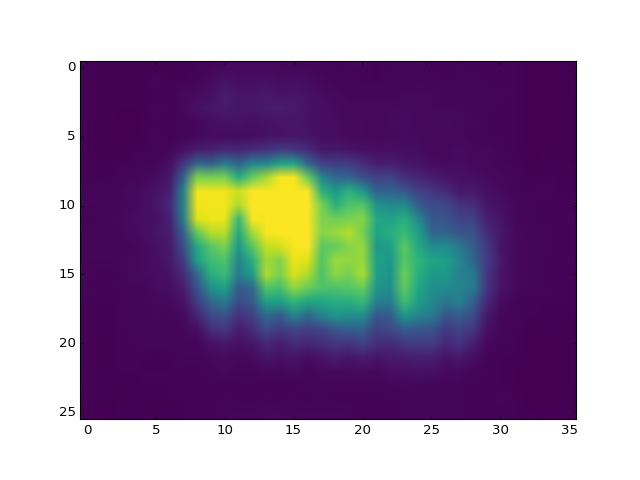

In [252]:
fig, ax = plt.subplots()
roi = [218, 818, 254, 844]
box = roi
ax.imshow(work_image[box[1]:box[3], box[0]:box[2]], cmap='viridis')

## plot the results

<IPython.core.display.Javascript object>


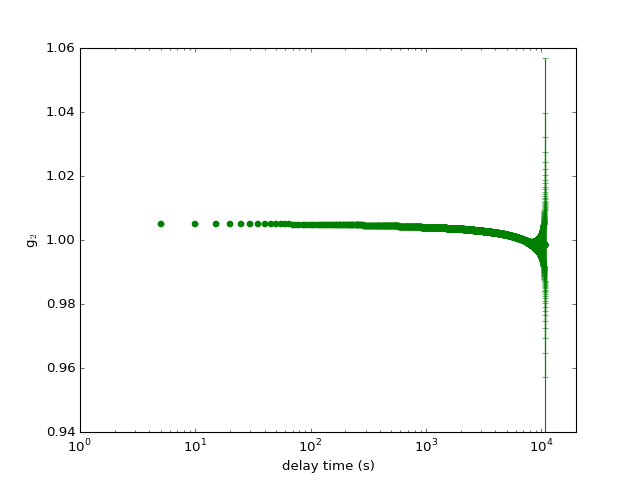

(1, 20000)

In [255]:
fig=plt.figure()
d=fig.add_subplot(1,1,1)
d.set_xlabel("delay time (s)")
d.set_ylabel("g$_2$")
plt.errorbar(t_arr, F, yerr=Err, marker='o', ls='none', color='g', mec='none')
d.set_xscale('log')
d.set_xlim(1,20000)

In [256]:
DataOut = np.column_stack((t_arr,F,Err))

np.savetxt('120K_0p2Hz_xpcs25_138nm_onres_56574.dat', DataOut) ##change filename appropriately